In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, cross_validate
from sklearn.metrics import accuracy_score, silhouette_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy import linalg
import xarray as xr
import numpy as np
import pandas as pd
import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Setup

In [2]:
from utils import *

plt.rc('legend', frameon=False)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_style("white", rc=custom_params)
sns.set_palette("pastel")

# Single Neuron Trial Summarized

## Plotting functions

In [3]:
def plot_auc(auc):
    plt.imshow(auc, aspect='auto', cmap='rocket')
    plt.ylabel('Neurons')
    plt.xlabel('Trials')
    plt.title('AUC of df/f per trial')
    plt.colorbar(label='AUC (df/f)')
    plt.show()

In [4]:
def plot_correlation_heatmap(df_results, metric='test_acc'):
    result = df_results.pivot(index='neuron', columns='target', values=metric)
    correlation_matrix = result.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, square=True)
    plt.title('Correlation between Target Decoding Accuracies')
    plt.tight_layout()
    plt.show()

In [5]:
def plot_pairwise(df_results, metric='test_acc'):
    result = df_results.pivot(index='neuron', columns='target', values=metric)
    
    # Custom function to add diagonal and chance lines
    def add_reference_lines(x, y, **kwargs):
        ax = plt.gca()
        # Diagonal line
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
        # Chance lines
        chance = 0.5
        ax.axhline(chance, color='k', linestyle='--', alpha=0.3, linewidth=1)
        ax.axvline(chance, color='k', linestyle='--', alpha=0.3, linewidth=1)
        # Scatter
        ax.scatter(x, y, alpha=0.2, s=10, marker='.', color='k')

    # Create pairplot with custom styling
    g = sns.pairplot(result, 
                    diag_kind='hist',
                    plot_kws={'alpha': 0.2, 's': 50, 'marker': '.', 'color': 'k'},
                    diag_kws={'color': 'k', 'alpha': 0.5},
                    corner=False,
                    height=3)  # Size of each subplot (default is 2.5)

    # Add reference lines to each subplot
    g.map_offdiag(add_reference_lines)

    # Set limits and grid for all subplots
    for ax in g.axes.flatten():
        if ax is not None:
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.grid(alpha=0.3)
            # Increase tick label size
            ax.tick_params(labelsize=10)

    # Increase axis label size
    for ax in g.axes[-1,:]:  # Bottom row (x-labels)
        ax.xaxis.label.set_size(12)
    for ax in g.axes[:,0]:   # Left column (y-labels)
        ax.yaxis.label.set_size(12)

    plt.suptitle(f"Pairwise Decoding {metric.replace('_', ' ').title()}", y=1.02, fontsize=14)
    plt.tight_layout()
    # set dpi 300
    plt.gcf().set_dpi(300)
    plt.show()

In [6]:
def plot_class_balance(trials_table):
    """
    Plot class balance for all 5 target variables as horizontal bar showing proportions.
    """
    ab_mask = (trials_table.context.values == 'ctxA') | (trials_table.context.values == 'ctxB')
    cd_mask = (trials_table.context.values == 'ctxC') | (trials_table.context.values == 'ctxD')
    
    # Define targets with their masks and class labels
    targets = [
        ('context_ab', trials_table.context.values, ab_mask, 'ctxA', 'ctxB'),
        ('context_cd', trials_table.context.values, cd_mask, 'ctxC', 'ctxD'),
        ('reward_trial', trials_table.reward_trial.values, np.ones(len(trials_table), dtype=bool), 'No Reward', 'Reward'),
        ('water', trials_table.water.values, np.ones(len(trials_table), dtype=bool), 'No Water', 'Water'),
        ('lick_or_not', trials_table.lick_or_not.values, np.ones(len(trials_table), dtype=bool), 'No Lick', 'Lick'),
    ]
    
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    
    for ax, (name, data, mask, label_0, label_1) in zip(axes, targets):
        masked_data = data[mask]
        unique_vals = np.unique(masked_data)
        
        # Calculate proportion of class 1 (second unique value)
        if len(unique_vals) == 2:
            prop_1 = np.mean(masked_data == unique_vals[1])
            prop_0 = 1 - prop_1
        else:
            prop_0, prop_1 = 0.5, 0.5
        
        # Plot horizontal stacked bar
        ax.barh(0, prop_0, color='steelblue', alpha=0.7, label=label_0)
        ax.barh(0, prop_1, left=prop_0, color='coral', alpha=0.7, label=label_1)
        
        # Add count annotations
        n_0 = int(prop_0 * len(masked_data))
        n_1 = int(prop_1 * len(masked_data))
        ax.text(prop_0/2, 0, f'{label_0}\n(n={n_0})', ha='center', va='center', fontsize=9, fontweight='bold')
        ax.text(prop_0 + prop_1/2, 0, f'{label_1}\n(n={n_1})', ha='center', va='center', fontsize=9, fontweight='bold')
        
        ax.set_ylabel(name, fontsize=10)
        ax.set_yticks([])
        ax.set_xlim(0, 1)
        ax.axvline(0.5, color='k', linestyle='--', alpha=0.5, linewidth=1)
    
    axes[-1].set_xlabel('Proportion', fontsize=11)
    axes[0].set_title('Class Balance for Each Target', fontsize=12)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_test_accuracy_by_neuron(df_results, metric='test_acc'):
    """
    Simple scatter plot of mean accuracy for all neurons, sorted.
    """
    # Pivot to get neurons x targets
    df_pivot = df_results.pivot(index='neuron', columns='target', values=metric)
    
    # Calculate mean across targets for each neuron
    mean_acc = df_pivot.mean(axis=1)
    n_total = len(mean_acc)
    
    # Sort neurons by mean accuracy (descending)
    sorted_neurons = mean_acc.sort_values(ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    
    y_pos = np.arange(n_total)[::-1]  # Best at top
    ax.scatter(sorted_neurons.values, y_pos, s=15, c='steelblue', alpha=0.7)
    
    # Chance line
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Chance')
    
    ax.set_xlim(0, 1)
    ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=11)
    ax.set_ylabel('Neuron (ranked)', fontsize=11)
    ax.set_title(f'All {n_total} Neurons', fontsize=12)
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return sorted_neurons.index

In [8]:
def plot_selectivity_histogram(df_results, n_bins=10, figsize=(12, 6)):
    """
    Histogram of signed selectivity per target showing neuron selectivity distribution.
    Signed selectivity = (AUC - 0.5) * sign(beta), centered at 0.
    """
    targets = df_results['target'].unique()
    n_targets = len(targets)
    
    fig, axes = plt.subplots(1, n_targets, figsize=figsize, sharey=True)
    
    for ax, target in zip(axes, targets):
        target_data = df_results[df_results['target'] == target]
        auc_values = target_data['test_auc'].values
        beta_values = target_data['beta_mean'].values
        
        # Signed selectivity: direction from beta, magnitude from AUC
        signed_selectivity = (auc_values - 0.5) * np.sign(beta_values)
        
        ax.hist(signed_selectivity, bins=n_bins, range=(-0.5, 0.5), 
                edgecolor='white', alpha=0.8)
        ax.axvline(0, color='k', linestyle='--', linewidth=1)
        ax.set_xlabel('Signed Selectivity')
        ax.set_title(target)
        ax.set_xlim(-0.55, 0.55)
    
    axes[0].set_ylabel('Number of neurons')
    plt.suptitle(r'Signed Selectivity = (AUC - 0.5) $\times$ sign($\beta$)', y=1.02)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_neuron_beta_clusters(df_results, max_clusters=10, figsize=(12, 5)):
    """
    PCA on neuron beta coefficients with k-means clustering overlay.
    Automatically selects optimal number of clusters via silhouette score.
    """
    
    # Pivot to wide format: neurons × targets
    beta_matrix = df_results.pivot(index='neuron', columns='target', values='beta_mean')
    
    # Z-score the betas
    scaler = StandardScaler()
    beta_scaled = scaler.fit_transform(beta_matrix.values)
    
    # Find optimal n_clusters via silhouette score
    k_range = range(2, min(max_clusters + 1, len(beta_matrix)))
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(beta_scaled)
        silhouette_scores.append(silhouette_score(beta_scaled, labels))
    
    n_clusters = list(k_range)[np.argmax(silhouette_scores)]
    
    # Final clustering with optimal k
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(beta_scaled)
    
    # PCA
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(beta_scaled)
    
    # Plot - two square subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Left: PCA scatter
    ax = axes[0]
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    for i in range(n_clusters):
        mask = clusters == i
        ax.scatter(pcs[mask, 0], pcs[mask, 1], c=[colors[i]], 
                   alpha=0.7, edgecolors='w', linewidth=0.5, label=f'Cluster {i}')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    ax.set_title(f'Neurons in Beta Space (k={n_clusters}, silhouette={max(silhouette_scores):.2f})')
    ax.legend(fontsize=8)
    ax.set_aspect('equal', 'box')
    
    # Right: Cluster profiles
    ax = axes[1]
    cluster_profiles = pd.DataFrame(beta_scaled, columns=beta_matrix.columns)
    cluster_profiles['cluster'] = clusters
    mean_profiles = cluster_profiles.groupby('cluster').mean()
    
    mean_profiles.T.plot(kind='bar', ax=ax, width=0.8, edgecolor='white', color=colors[:n_clusters])
    ax.set_xlabel('Target')
    ax.set_ylabel('Mean Beta (z-scored)')
    ax.set_title('Cluster Encoding Profiles')
    ax.legend(title='Cluster', fontsize=8)
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax.set_aspect('auto')
    
    plt.tight_layout()
    plt.show()

## Analysis

Different targets to decode:

$$\text{CTX}^{AB}_{trial} = \beta_0 + \beta_1 \cdot \text{AUC}[\text{df/f}_{trial}]$$
$$\text{CTX}^{CD}_{trial} = \beta_0 + \beta_1 \cdot \text{AUC}[\text{df/f}_{trial}]$$
$$\text{RW}_{trial} = \beta_0 + \beta_1 \cdot \text{AUC}[\text{df/f}_{trial}]$$
$$\text{WATER}_{trial} = \beta_0 + \beta_1 \cdot \text{AUC}[\text{df/f}_{trial}]$$
$$\text{LICK}_{trial} = \beta_0 + \beta_1 \cdot \text{AUC}[\text{df/f}_{trial}]$$

In [10]:
def single_neuron_decoding(auc, trials_table):
    """
    Perform single neuron decoding using logistic regression with 5-fold cross-validation.
    """
    
    ab_mask = (trials_table.context.values == 'ctxA') | (trials_table.context.values == 'ctxB')
    cd_mask = (trials_table.context.values == 'ctxC') | (trials_table.context.values == 'ctxD')

    target_names = [
        'context_ab', 
        'context_cd', 
        'reward_trial', 
        'water', 
        'lick_or_not'
    ]

    target_datas = [
        trials_table.context.values,
        trials_table.context.values,
        trials_table.reward_trial.values,
        trials_table.water.values,
        trials_table.lick_or_not.values
    ]

    trial_masks = [
        ab_mask,
        cd_mask,
        np.ones(len(trials_table), dtype=bool),
        np.ones(len(trials_table), dtype=bool),
        np.ones(len(trials_table), dtype=bool)
    ]


    results = []
    for neuron_idx in tqdm.tqdm(range(auc.shape[0]), desc='Decoding neurons'):
        
        
        for target_name, target_data, trial_mask in zip(target_names, target_datas, trial_masks):
            
            neuron_auc = auc[neuron_idx, trial_mask].reshape(-1, 1)
            
            model = LogisticRegression(max_iter=1000)
            kfold = KFold(n_splits=5, shuffle=True, random_state=42)
            
            scoring = {
                'accuracy': 'accuracy',
                'roc_auc': 'roc_auc',
            }
            
            cv_results = cross_validate(model, 
                                        neuron_auc, 
                                        target_data[trial_mask], 
                                        cv=kfold, 
                                        scoring=scoring, 
                                        return_train_score=True,
                                        return_estimator=True)
            
            # betas from each fold's fitted model
            betas = np.array([est.coef_[0, 0] for est in cv_results['estimator']])
            intercepts = np.array([est.intercept_[0] for est in cv_results['estimator']])
            
            results.append({
                'neuron': neuron_idx,
                'target': target_name,
                'train_acc': cv_results['train_accuracy'].mean(),
                'test_acc': cv_results['test_accuracy'].mean(),
                'train_auc': cv_results['train_roc_auc'].mean(),
                'test_auc': cv_results['test_roc_auc'].mean(),
                'beta_mean': betas.mean(),
                'beta_std': betas.std(),
                'beta_folds': betas.tolist(),  # if you want all 5
                'intercept_mean': intercepts.mean(),
            })

    return pd.DataFrame(results)

# Single Neuron Temporal

## Plotting functions

In [11]:
def plot_temporal_encoding(ds, metric='test_auc', figsize=(10, 6)):
    """
    Plot time-resolved encoding: mean ± SEM across neurons for each target.
    """
    data = ds[metric]  # (neuron, target, time)
    
    time = ds.coords['time'].values
    targets = ds.coords['target'].values
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(targets)))
    
    for i, target in enumerate(targets):
        target_data = data.sel(target=target)  # (neuron, time)
        
        mean_val = target_data.mean(dim='neuron').values
        sem_val = target_data.std(dim='neuron').values / np.sqrt(len(ds.coords['neuron']))
        
        ax.plot(time, mean_val, label=target, color=colors[i], linewidth=2)
        ax.fill_between(time, mean_val - sem_val, mean_val + sem_val, 
                        color=colors[i], alpha=0.2)
    
    ax.axhline(0.5, color='k', linestyle='--', linewidth=1, label='chance')
    ax.axvline(0, color='gray', linestyle=':', linewidth=1)
    
    ax.set_xlabel('Steps from trial onset')
    ax.set_ylabel(metric)
    ax.set_title(f'Temporal Encoding Dynamics ({metric})')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

## Analysis

In [12]:
def single_neuron_decoding_temporal(dfof, trials_table, bin_size=5, fs=1.0):
    """
    Time-resolved single neuron decoding using binned activity.
    
    Parameters
    ----------
    dfof : np.ndarray
        Shape (n_neurons, n_trials, n_timepoints)
    trials_table : pd.DataFrame
        Must have columns: context, reward_trial, water, lick_or_not
    bin_size : int
        Number of frames to bin together via trapz
    fs : float
        Sampling rate in Hz, used to create time axis
        
    Returns
    -------
    xr.Dataset
        Dimensions: (neuron, target, time)
        Variables: test_auc, beta, intercept
    """
    
    n_neurons, n_trials, n_timepoints = dfof.shape
    n_bins = n_timepoints // bin_size
    
    # Bin via trapz: (n_neurons, n_trials, n_timepoints) -> (n_neurons, n_trials, n_bins)
    dfof_truncated = dfof[:, :, :n_bins * bin_size]  # trim to fit evenly
    dfof_reshaped = dfof_truncated.reshape(n_neurons, n_trials, n_bins, bin_size)
    dfof_binned = np.trapz(dfof_reshaped, axis=-1)
    
    # Time vector (bin centers)
    frame_times = np.arange(n_timepoints) / fs
    bin_centers = frame_times[:n_bins * bin_size].reshape(n_bins, bin_size).mean(axis=1)
    
    # Target setup (same as before)
    ab_mask = (trials_table.context.values == 'ctxA') | (trials_table.context.values == 'ctxB')
    cd_mask = (trials_table.context.values == 'ctxC') | (trials_table.context.values == 'ctxD')
    
    target_names = ['context_ab', 'context_cd', 'reward_trial', 'water', 'lick_or_not']
    target_datas = [
        trials_table.context.values,
        trials_table.context.values,
        trials_table.reward_trial.values,
        trials_table.water.values,
        trials_table.lick_or_not.values
    ]
    trial_masks = [ab_mask, cd_mask, 
                   np.ones(n_trials, dtype=bool),
                   np.ones(n_trials, dtype=bool),
                   np.ones(n_trials, dtype=bool)]
    
    # Preallocate arrays
    n_targets = len(target_names)
    auc_arr = np.full((n_neurons, n_targets, n_bins), np.nan)
    beta_arr = np.full((n_neurons, n_targets, n_bins), np.nan)
    intercept_arr = np.full((n_neurons, n_targets, n_bins), np.nan)
    
    # Main loop
    for neuron_idx in tqdm.tqdm(range(n_neurons), desc='Temporal decoding'):
        for t_idx in range(n_bins):
            for target_idx, (target_name, target_data, trial_mask) in enumerate(
                zip(target_names, target_datas, trial_masks)
            ):
                X = dfof_binned[neuron_idx, trial_mask, t_idx].reshape(-1, 1)
                y = target_data[trial_mask]
                
                model = LogisticRegression(max_iter=1000)
                model.fit(X, y)
                
                y_prob = model.predict_proba(X)[:, 1]
                auc_arr[neuron_idx, target_idx, t_idx] = roc_auc_score(y, y_prob)
                beta_arr[neuron_idx, target_idx, t_idx] = model.coef_[0, 0]
                intercept_arr[neuron_idx, target_idx, t_idx] = model.intercept_[0]
    
    # Build xarray Dataset
    ds = xr.Dataset(
        {
            'test_auc': (['neuron', 'target', 'time'], auc_arr),
            'beta': (['neuron', 'target', 'time'], beta_arr),
            'intercept': (['neuron', 'target', 'time'], intercept_arr),
        },
        coords={
            'neuron': np.arange(n_neurons),
            'target': target_names,
            'time': bin_centers,
        }
    )
    
    return ds



# Main

Mouse: ek045, Trial ID: 34941, Area: CA1
ICRWL.h5 is successfully loaded


Decoding neurons:   0%|          | 0/702 [00:00<?, ?it/s]

place_maps.pkl is successfully loaded


Temporal decoding: 100%|██████████| 702/702 [04:12<00:00,  2.78it/s]


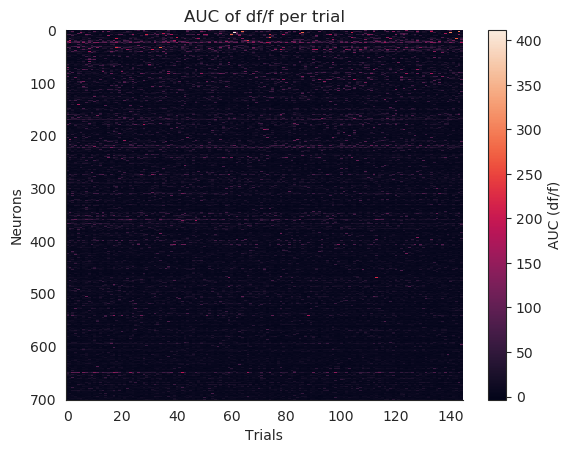

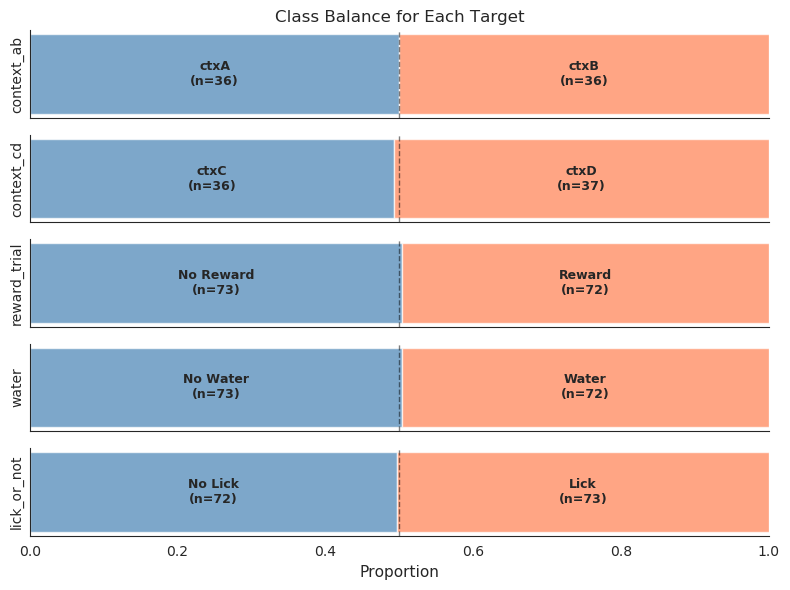

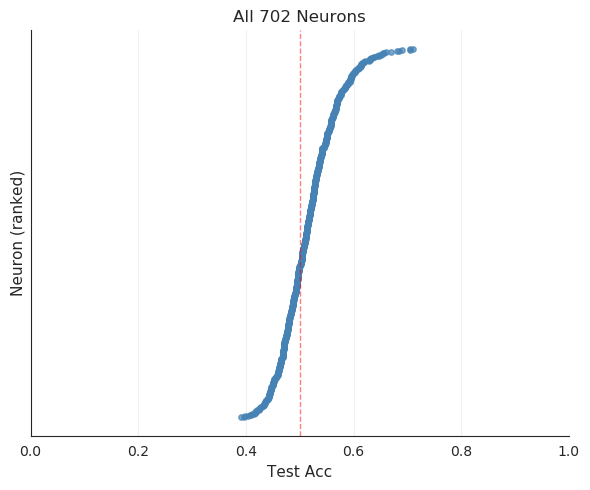

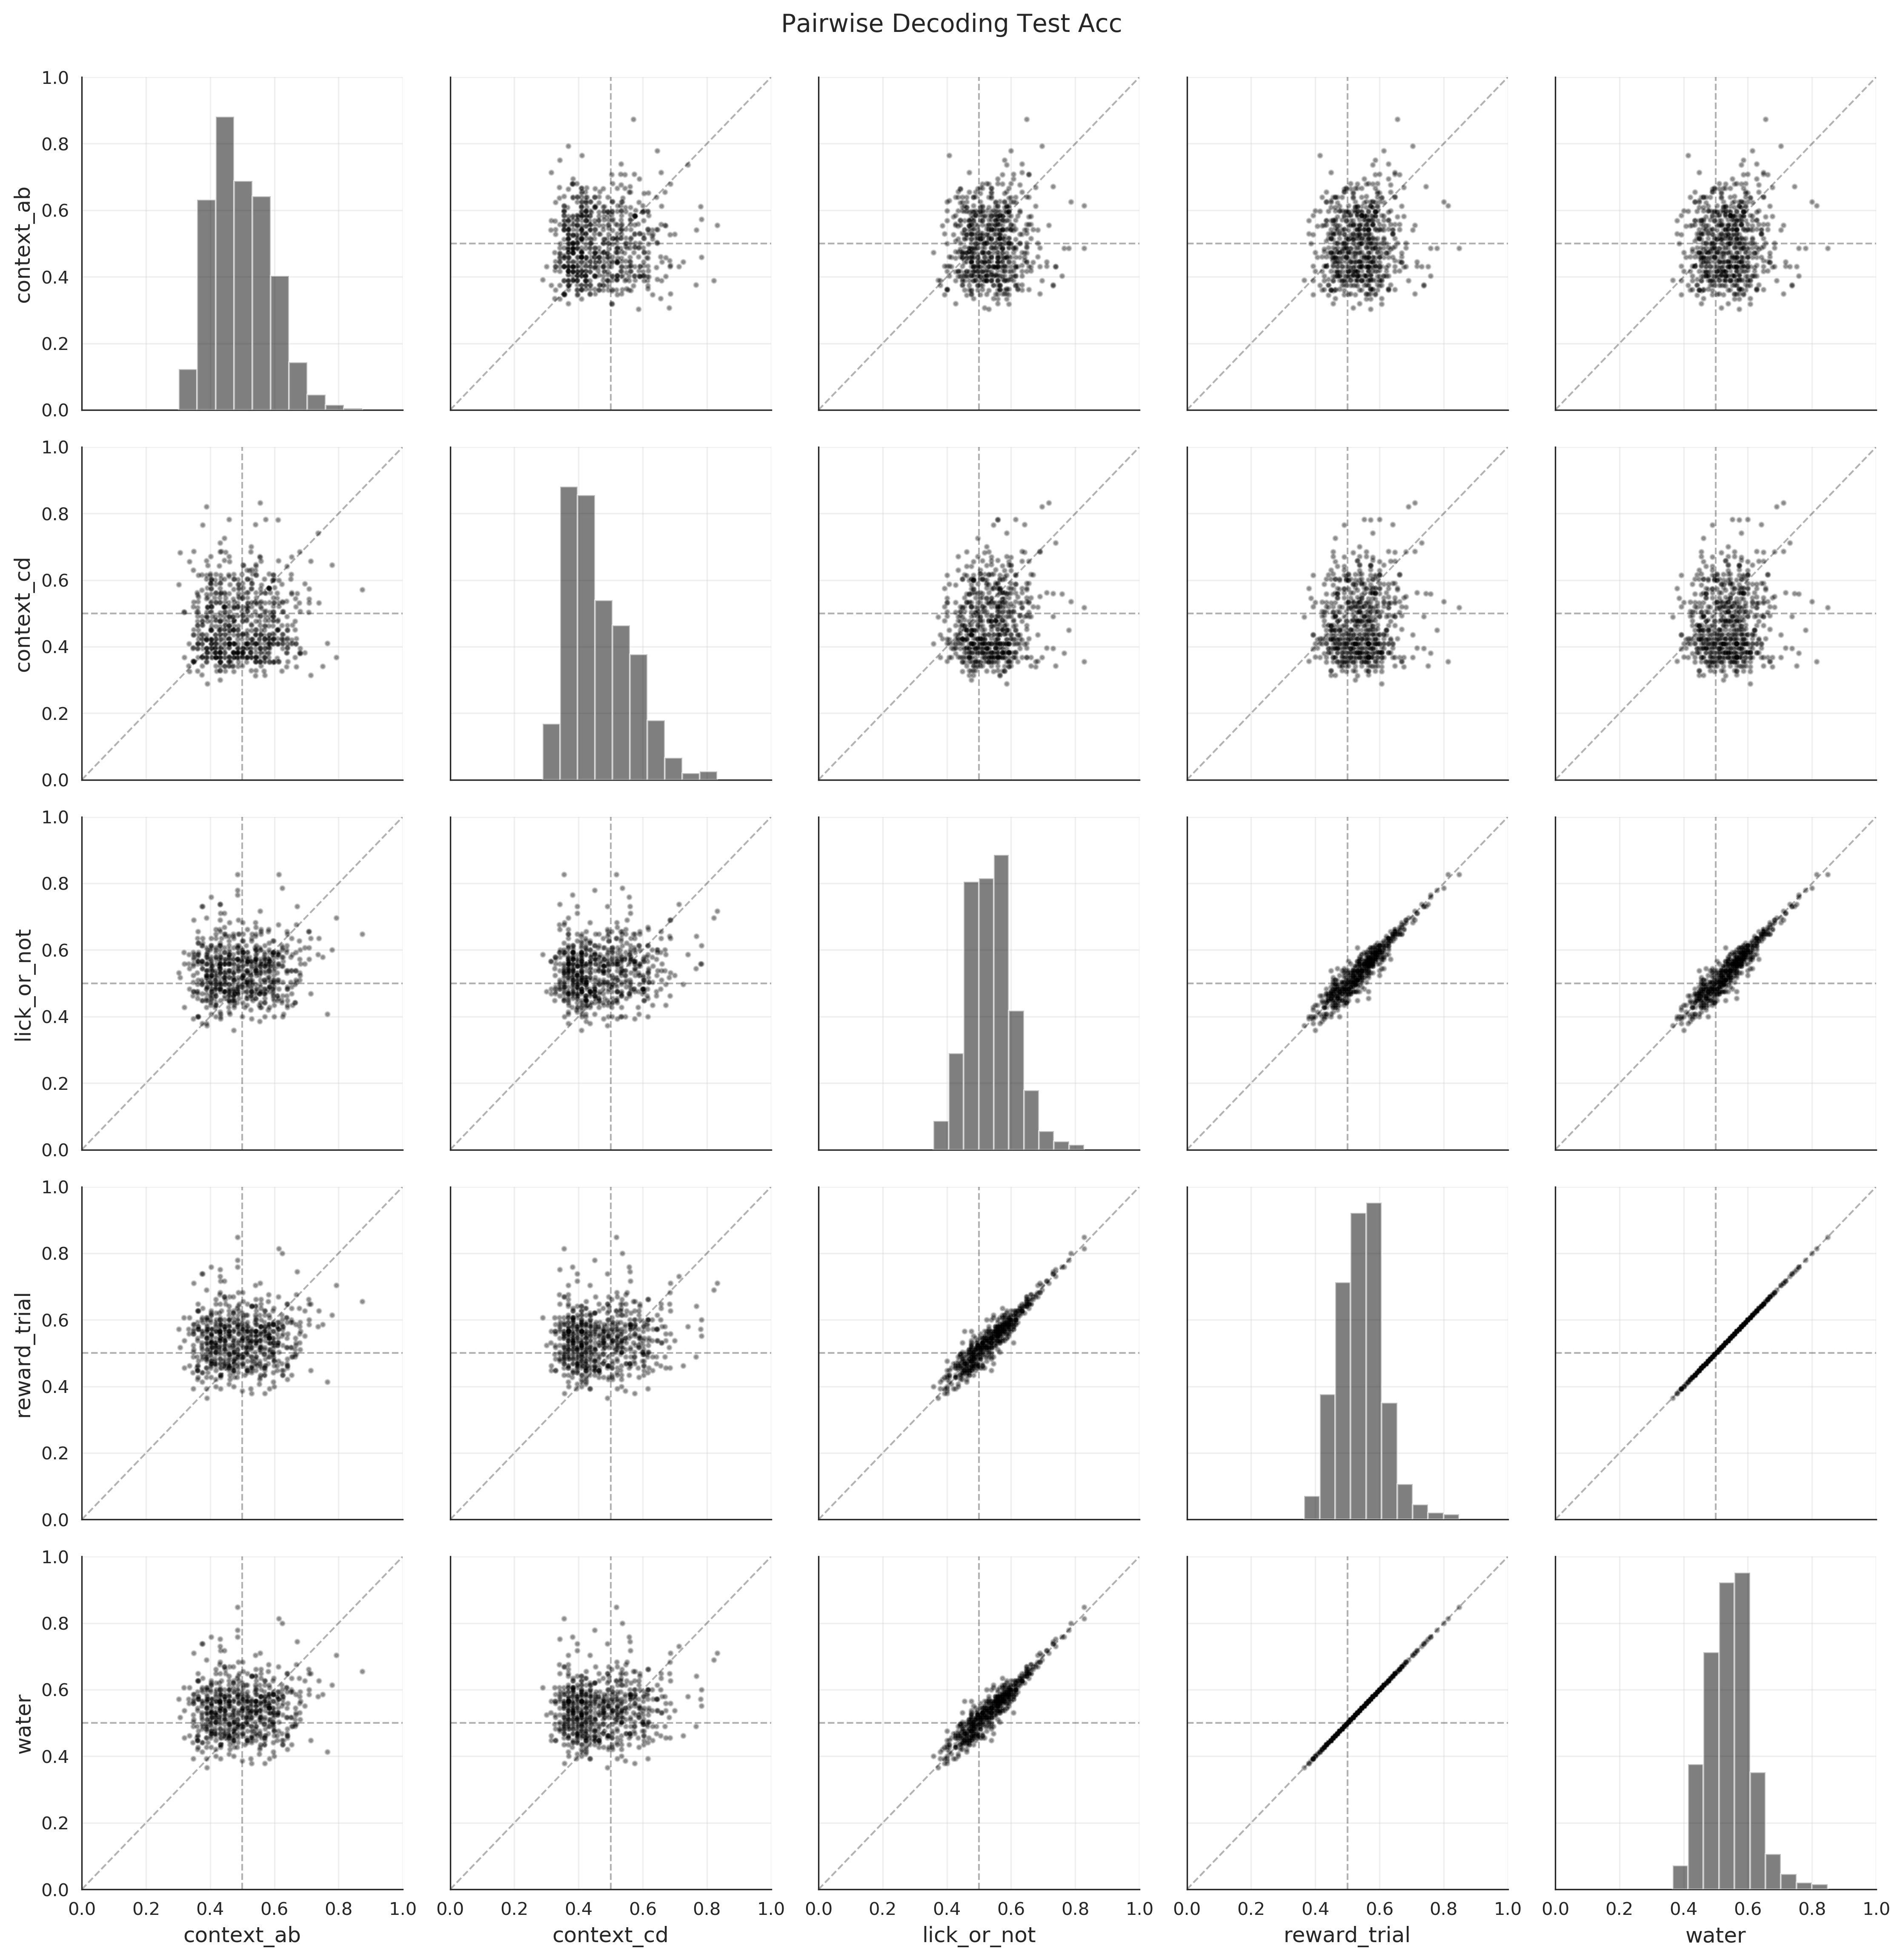

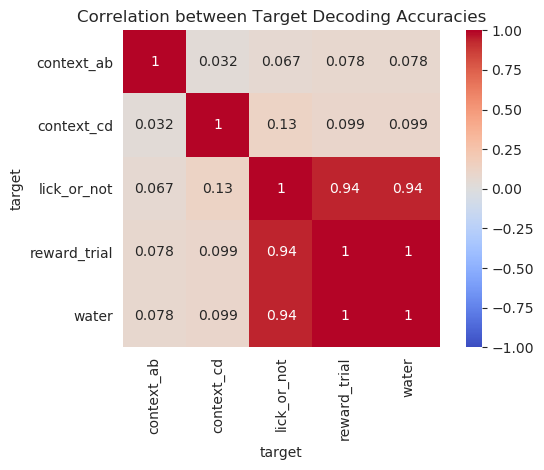

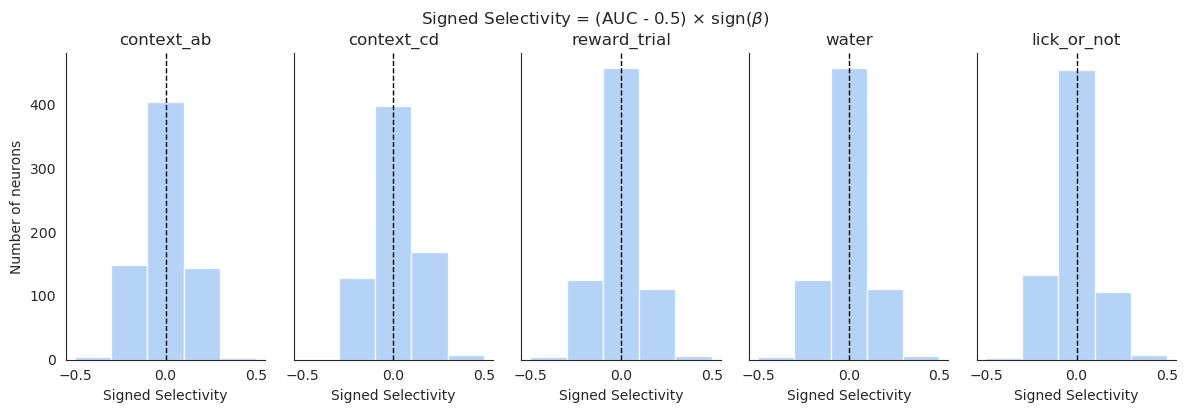

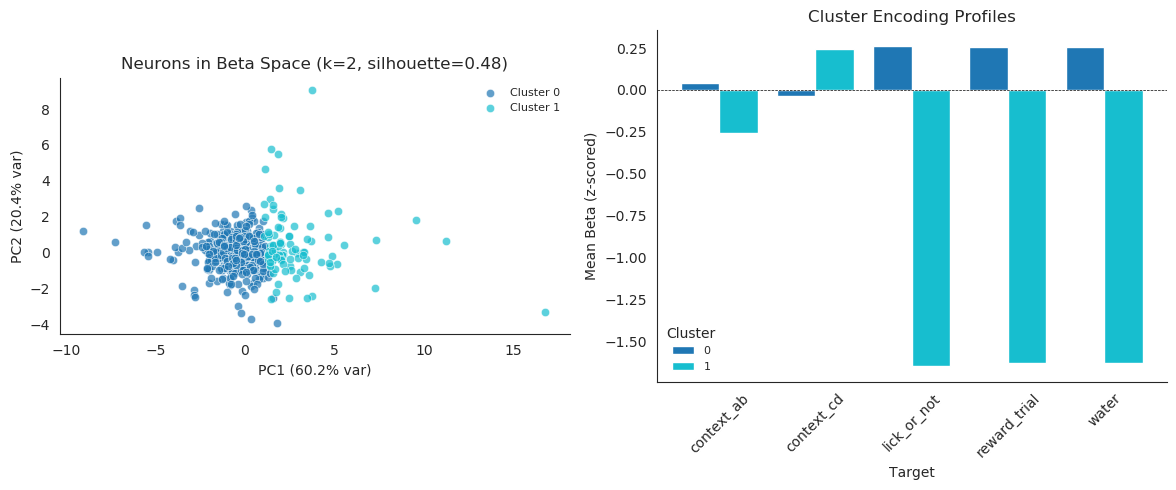

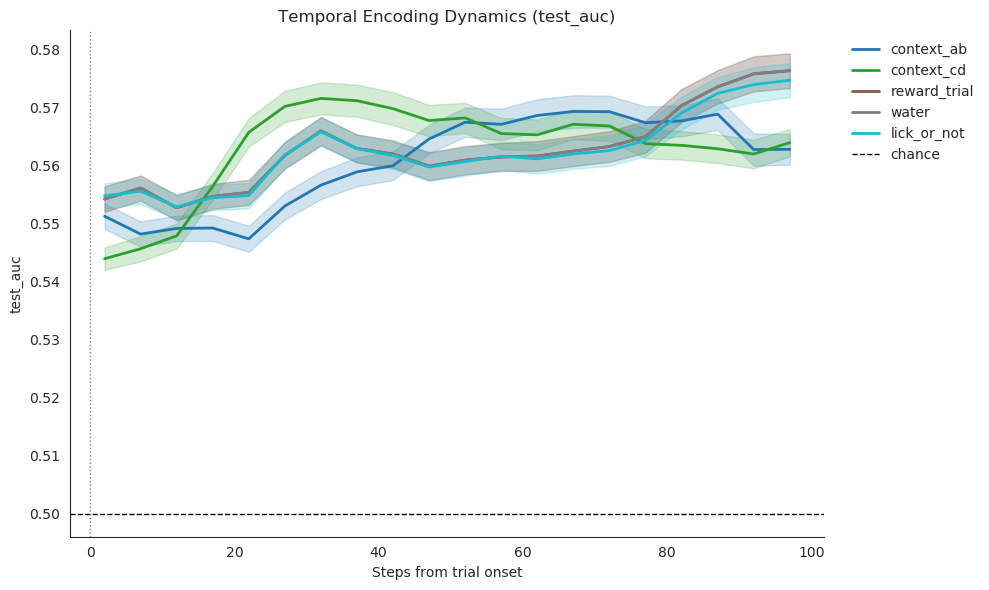

Mouse: ek045, Trial ID: 34948, Area: CA1
ICRWL.h5 is successfully loaded


Decoding neurons:   0%|          | 0/693 [00:00<?, ?it/s]

place_maps.pkl is successfully loaded


Temporal decoding: 100%|██████████| 693/693 [04:07<00:00,  2.80it/s]


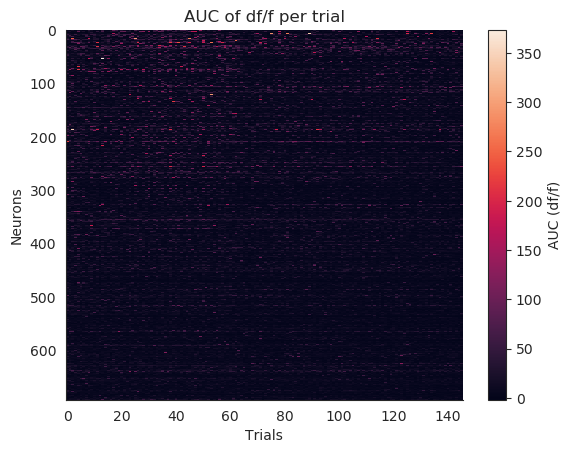

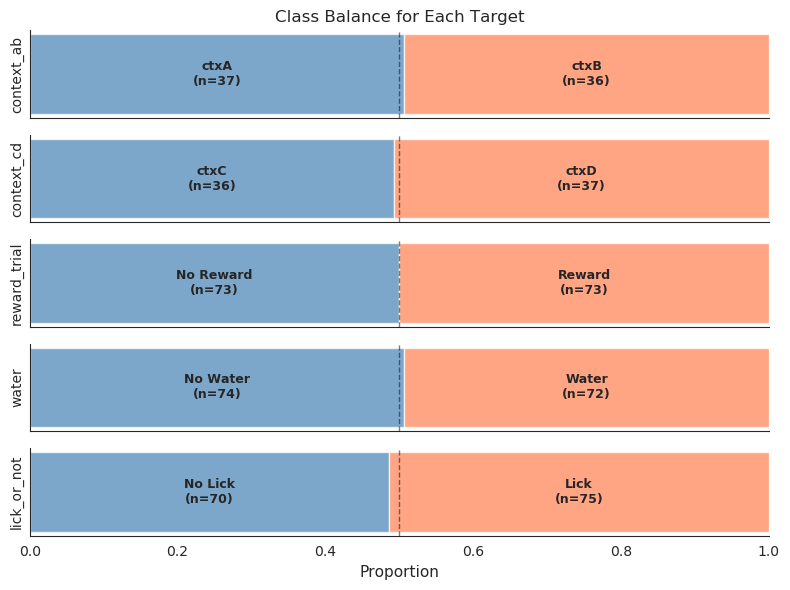

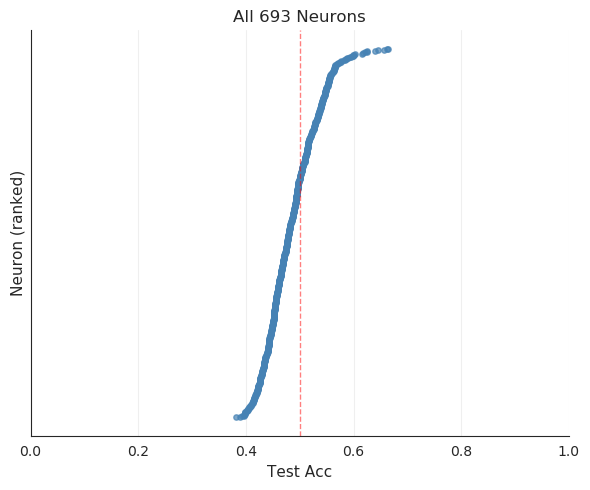

In [ ]:
for index, row in df_experiments.iterrows():
    print(f"Mouse: {row['mouse_id']}, Trial ID: {row['trial_id']}, Area: {row['area']}")
    
    # Lets read
    mouse = Mouse.from_database(
        trial_id=row['trial_id'],
        mouse_name=row['mouse_id'],
        expt_class=ImagingExperiment
    ) # returns df
    expt = mouse[0] # df
    bd_exp = expt.format_behavior_data() # dict
    # for key in bd_exp.keys(): print(key)
    
    # Get or Make ICRWL and place maps
    ICRWL = get_or_make_ICRWL(expt, bd_exp)
    place_maps, smooth_place_maps = get_or_make_place_maps(expt)
    
    trials_table = ICRWL.reset_index()[['lap_index', 'context', 'reward_trial', 'water', 'lick_or_not']]
    
    # Cropping cuz smooth place maps records more trails than behavioral data
    dfof = smooth_place_maps[:,:len(trials_table), :]
    auc = np.trapz(dfof, axis=2)
    
    # Core analysis
    df_results = single_neuron_decoding(auc, trials_table)
    xr_results = single_neuron_decoding_temporal(dfof, trials_table, bin_size=5, fs=1.0)
    
    # Plot the df results
    plot_auc(auc) # Basically the raw feature matrix
    plot_class_balance(trials_table)
    plot_test_accuracy_by_neuron(df_results, metric='test_acc') # Accuracy summary for all neurons
    plot_pairwise(df_results, metric='test_acc') # Target x Target pairwise plots
    plot_correlation_heatmap(df_results) # Correlation in accuracy between targets
    plot_selectivity_histogram(df_results, n_bins=5, figsize=(12, 4)) # Histogram of ROC per target
    plot_neuron_beta_clusters(df_results, max_clusters=10, figsize=(12,5))
    
    # Plot the xr results
    plot_temporal_encoding(xr_results, metric='test_auc', figsize=(10,6))

In [ ]:
plot_selectivity_histogram(df_results, n_bins=5, figsize=(16, 3))